In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy.ndimage import gaussian_filter1d

# 设置全局字体
matplotlib.rcParams["font.family"] = "SimSun"
raw_data = pd.read_csv(r"data\qiyeshuju-4S间隔.csv", encoding="gbk")
raw_data.index = pd.to_datetime(raw_data["时间"])
raw_data.drop("时间", axis=1, inplace=True)

columns = raw_data.columns
print(columns)



Index(['右侧换火信号', 'CEMS出口烟尘($mg/m^{3}$)', 'CEMS出口一氧化氮($mg/m^{3}$)',
       'VA.SO2($mg/m^{3}$)', 'VA.NOX($mg/m^{3}$)', 'CEMS出口含氧(%)', 'VA.O2(%)',
       'NOX转换值($mg/m^{3}$)', '氨水泵B频率反馈(Hz)', '1#线氨水流量(L/h)', 'C泵频率反馈(Hz)',
       '反应塔入口温度', '1#线氨水调节阀(L/h)', '反应塔出口温度', 'CCF出口温度', '氨水分段设定反馈($m^{3}/h$)',
       'CCF6温度', 'CCF5温度', 'CCF4温度', 'CCF3温度', 'CCF2温度', '出口CEMS温度', 'CCF1温度',
       'CCF7温度', '喷氨压缩空气压力', 'CCF1差压', 'CCF2差压', 'CCF3差压', 'CCF4差压', 'CCF5差压',
       '反应塔差压', 'CCF6差压', 'B变频器电流(A)', 'A变频器电流(A)', 'B输出频率(Hz)',
       '氨逃逸小时均值($mg/m^{3}$)', 'A输出频率(Hz)', 'CCF7差压', '烟气量($Nm^{3}/h$)',
       'CCF出口压力', 'CEMS出口流量(m/s)', '22出口CEMS温度', '22CEMS出口烟尘($mg/m^{3}$)',
       '出口CEMS湿度(%)', '22烟气量($Nm^{3}/h$)', '右侧换火信号-数值'],
      dtype='object')


DatetimeIndex(['2023-12-11 18:48:28', '2023-12-11 18:48:32',
               '2023-12-11 18:48:36', '2023-12-11 18:48:40',
               '2023-12-11 18:48:44', '2023-12-11 18:48:48',
               '2023-12-11 18:48:52', '2023-12-11 18:48:56',
               '2023-12-11 18:49:00', '2023-12-11 18:49:04',
               ...
               '2024-01-12 17:09:32', '2024-01-12 17:09:36',
               '2024-01-12 17:09:40', '2024-01-12 17:09:44',
               '2024-01-12 17:09:48', '2024-01-12 17:09:52',
               '2024-01-12 17:09:56', '2024-01-12 17:10:00',
               '2024-01-12 17:10:04', '2024-01-12 17:10:08'],
              dtype='datetime64[ns]', name='时间', length=690336, freq=None)


<Axes: xlabel='时间'>

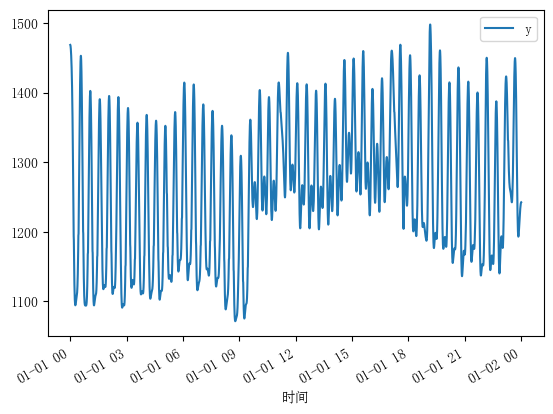

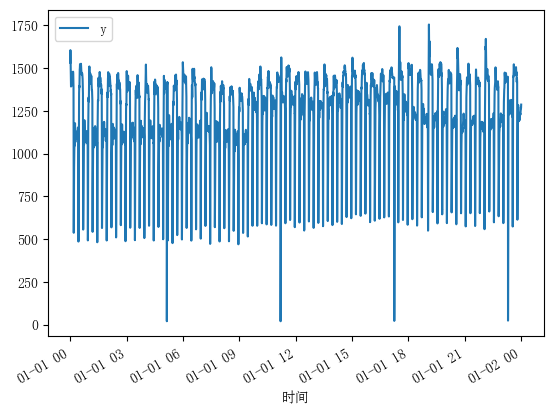

In [14]:
# 选择一天的数据
print(raw_data.index) 
one_data = raw_data["2024-01-1 00:00:00":"2024-01-1 23:59:59"]

test_data = one_data[[r"VA.NOX($mg/m^{3}$)"]]
test_data.columns = ["y"]

origin_test_data = test_data.copy()
## 去除异常值
# 阈值去除
# mask = test_data['y'] < 750
# test_data.loc[mask, 'y'] = np.nan
# test_data['y'].fillna(method='ffill', inplace=True)

# Z-score去除
# test_data.columns = ['ds', 'y']   # 假设 'ds' 是日期，'y' 是值
test_data.loc[:, "ds"] = test_data.index
# 计算 Z-score
test_data['z'] = (test_data['y'] - test_data['y'].mean()) / test_data['y'].std()
test_data = test_data[(test_data['z'] > -3) & (test_data['z'] < 3)]



# 滤波处理
# Apply Gaussian smoothing to the 'y' column of test_data
test_data['y'] = gaussian_filter1d(test_data['y'], sigma=50)


test_data.loc[:, "ds"] = test_data.index
test_data.loc[:, "unique_id"] = [1.0 for i in range(len(test_data))]
test_data.plot(y='y')
origin_test_data.plot(y="y")


In [4]:
n = len(test_data)
train = test_data.iloc[: int(n * 0.9), :]
test = test_data.iloc[int(n * 0.9) :, :]
print(n)

21293


In [5]:
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS, LSTM, GRU,TCN, TimesNet,Informer
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss
# Split data and declare panel dataset
Y_train_df = train
Y_test_df = test
print(len(Y_train_df))
print(len(Y_test_df))

19163
2130


In [47]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic, augment_calendar_df

infomer_modle = Informer(h=12,
                 input_size=24,
                 hidden_size = 16,
                 conv_hidden_size = 32,
                 n_head = 2,
                 #loss=DistributionLoss(distribution='StudentT', level=[80, 90]),
                #  loss=MAE(),
                #  futr_exog_list=calendar_cols,
                 scaler_type='robust',
                 learning_rate=1e-3,
                 max_steps=5,
                 val_check_steps=50,
                 early_stop_patience_steps=2)


model = TimesNet(h=12,
                 input_size=24,
                 hidden_size = 16,
                 conv_hidden_size = 32,
                 #loss=MAE(),
                 #loss=MQLoss(quantiles=[0.2, 0.5, 0.8]),
                 loss=DistributionLoss(distribution='Normal', level=[80, 90]),
                #  futr_exog_list=calendar_cols,
                 scaler_type='standard',
                 learning_rate=1e-3,
                 max_steps=5,
                 val_check_steps=50,
                 early_stop_patience_steps=2)

c:\Users\glx\anaconda3\envs\ft\lib\site-packages\pytorch_lightning\utilities\parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
Seed set to 1
Seed set to 1


In [6]:

# Fit and predict with NBEATS and NHITS models
horizon = len(Y_test_df)
models = [
          NBEATS(input_size=2 * horizon, h=horizon, max_steps=50),
          NHITS(input_size=2 * horizon, h=horizon, max_steps=200),
          LSTM(h=horizon,                    # Forecast horizon
               max_steps=50,                # Number of steps to train
               scaler_type='standard',       # Type of scaler to normalize data
               encoder_hidden_size=64,       # Defines the size of the hidden state of the LSTM
               decoder_hidden_size=64,),
          GRU(h=horizon,                    # Forecast horizon
               max_steps=50,                # Number of steps to train
               scaler_type='standard',       # Type of scaler to normalize data
               encoder_hidden_size=64,       # Defines the size of the hidden state of the LSTM
               decoder_hidden_size=64,)                   # Forecast horizon
          ]

nf = NeuralForecast(models=models, freq='4s')
nf.fit(df=Y_train_df)
Y_hat_df = nf.predict().reset_index()

Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])



Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


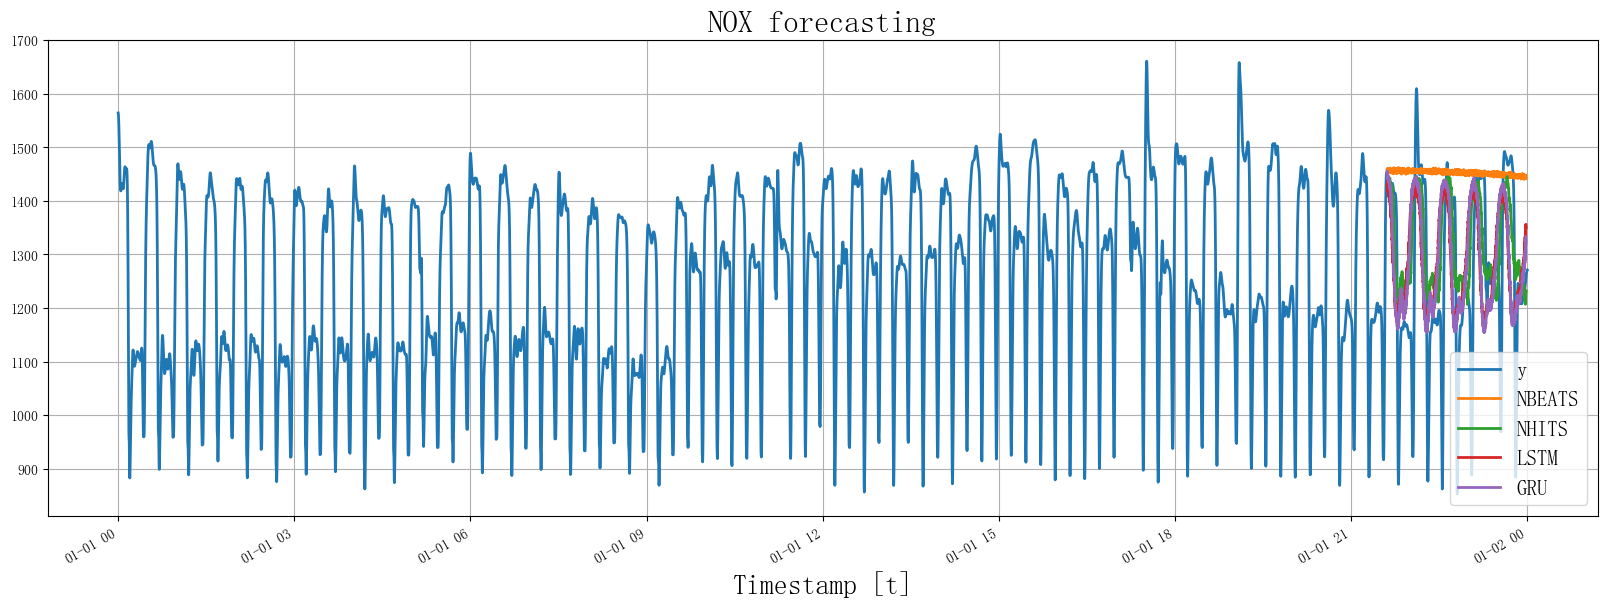

In [7]:
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
plot_df.drop(['unique_id','z'], axis=1).plot(ax=ax, linewidth=2)

ax.set_title('NOX forecasting', fontsize=22)
ax.set_ylabel('', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

plot_df.drop(['unique_id','z'], axis=1).plot(ax=ax, linewidth=2)
# 首先，我们需要确定Y_hat_df中哪些列是模型的名字
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')
model_names = Y_hat_df.columns.difference(['unique_id', 'z', "y","ds"])

# # 然后，我们可以遍历这些模型名称，为每个模型创建一个图
for model_name in model_names:
    # 我们只选择当前模型的预测结果，以及训练数据
    model_df = plot_df[['y', model_name]].copy()
    # 创建图
    fig, ax = plt.subplots(1, 1, figsize = (20, 7))
    model_df.plot(ax=ax, linewidth=2)

    # 设置图的标题、标签等
    ax.set_title(f'NOX forecasting ({model_name})', fontsize=22)
    ax.set_ylabel('emission', fontsize=20)
    ax.set_xlabel('Timestamp [t]', fontsize=20)
    ax.legend(prop={'size': 15})
    ax.grid()

    # 保存图像
    plt.savefig(f'forecast_result\{model_name}.jpg')

    # 关闭图像，以释放内存
    plt.close(fig)

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from copy import deepcopy

def evaluate_forecast(y_true, y_pred):
    # 假设 y_true 是真实值，y_pred 是预测值
    # 计算MSE
    mse = mean_squared_error(y_true, y_pred)
    print('MSE: ', mse)

    # 计算RMSE
    rmse = np.sqrt(mse)
    print('RMSE: ', rmse)

    # 计算MAE
    mae = mean_absolute_error(y_true, y_pred)
    print('MAE: ', mae)

    # 计算MAPE
    mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    print('MAPE: %', mape)

    # use a pd.DataFrame to store the results
    results = pd.DataFrame({'MSE': [mse], 'RMSE': [rmse], 'MAE': [mae], 'MAPE': [mape]})
    return results
    

In [21]:
def get_model_name(Y_hat_df):
    columns = Y_hat_df.columns
    model_names = []
    for column in columns:
        if column.isupper():
            model_names.append(column)
    return model_names

Y_hat_org = Y_hat_df.dropna()
all_model_result = {}
for model_name in get_model_name(Y_hat_df):
    y_true = Y_hat_org['y']
    y_pred = Y_hat_org[model_name]
    model_evaluate_result = evaluate_forecast(y_true[:2110], y_pred)
    all_model_result[model_name] = deepcopy(model_evaluate_result)

print(all_model_result)

MSE:  60831.051588380695
RMSE:  246.6395174913799
MAE:  191.23984821536604
MAPE: % 17.092988142444156
MSE:  20798.542517232214
RMSE:  144.2169980176824
MAE:  97.80069438574118
MAPE: % 8.728034864864803
MSE:  30563.92637459241
RMSE:  174.8254168437542
MAE:  135.1215148144102
MAPE: % 11.383664803667209
MSE:  29701.80014994166
RMSE:  172.34210208170742
MAE:  126.57191281293522
MAPE: % 10.730301374089473
{'NBEATS':             MSE        RMSE         MAE       MAPE
0  60831.051588  246.639517  191.239848  17.092988, 'NHITS':             MSE        RMSE        MAE      MAPE
0  20798.542517  144.216998  97.800694  8.728035, 'LSTM':             MSE        RMSE         MAE       MAPE
0  30563.926375  174.825417  135.121515  11.383665, 'GRU':            MSE        RMSE         MAE       MAPE
0  29701.80015  172.342102  126.571913  10.730301}


In [27]:
result= pd.concat(all_model_result, axis=0) # 纵向拼接结果
result.reset_index(level=1, inplace=True) # 修改index
result.drop('level_1', axis=1, inplace=True) # 删除多余的列
result.to_csv(r"forecast_result\result.csv")

In [28]:
result

,MSE,RMSE,MAE,MAPE
NBEATS,60831.051588,246.639517,191.239848,17.092988
NHITS,20798.542517,144.216998,97.800694,8.728035
LSTM,30563.926375,174.825417,135.121515,11.383665
GRU,29701.800150,172.342102,126.571913,10.730301
